In [1]:
import torch
from transformers import AutoTokenizer
from transformers.models.llama import LlamaForCausalLM
from transformers.models.llama.modeling_llama import LlamaMLP
from torch.utils.data import DataLoader
from datasets import load_dataset
from model import *

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-04-21 06:48:51.221017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745218133.598377   18970 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745218134.283719   18970 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745218139.228596   18970 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745218139.228637   18970 comp

In [ ]:
dtype = torch.bfloat16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and base model
tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token

base_model = LlamaForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-Instruct", torch_dtype=dtype)
base_model.to(device)
base_model.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-0

In [4]:
speculator_head = PredictorHead(base_model.model.config)
speculator_head.load_state_dict(torch.load("../new_nn_decoder_head1.pth"))
speculator_head.to(device, dtype=dtype)
specModel = TwoHeadModel(base_model, speculator_head)
specModel.to(device, dtype=dtype)
specModel.eval()

TwoHeadModel(
  (base_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
      (layers): ModuleList(
        (0-15): 16 x LlamaDecoderLayer(
          (self_attn): LlamaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=512, bias=False)
            (v_proj): Linear(in_features=2048, out_features=512, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
          (post_attention_layernorm): LlamaRMSNorm((2048,), e

In [5]:
class PrefixTuningModel(nn.Module):
    def __init__(self, base_model, speculator_head, prefix_length):
        """
        Args:
            base_model: The pre-trained LlamaForCausalLM model.
            speculator_head: The additional head (predicting the second token).
            prefix_length: Number of trainable prefix tokens.
        """
        super(PrefixTuningModel, self).__init__()
        self.base_model = base_model
        self.prefix_length = prefix_length
        self.hidden_size = base_model.config.hidden_size
        self.prefix_embeddings = nn.Parameter(torch.randn(prefix_length, self.hidden_size, dtype=dtype))
        self.main_head = base_model.lm_head
        self.speculator_head = speculator_head

    def forward(self, input_ids, attention_mask=None):
        batch_size = input_ids.shape[0]
        input_embeds = self.base_model.model.embed_tokens(input_ids)  # shape: [batch, seq_len, hidden_size]
        prefix_embeds = self.prefix_embeddings.unsqueeze(0).expand(batch_size, -1, -1)
        concat_embeds = torch.cat([prefix_embeds, input_embeds], dim=1)
        if attention_mask is not None:
            prefix_mask = torch.ones(batch_size, self.prefix_length, device=attention_mask.device)
            attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)
        outputs = self.base_model.model(inputs_embeds=concat_embeds, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # shape: [batch, (prefix+seq_len), hidden_size]
        logits_main = self.main_head(hidden_states)
    
        batch_size, seq_len, _ = hidden_states.shape
        logits_speculator = self.speculator_head(hidden_states)
        return logits_main, logits_speculator

In [6]:
from torch.optim.lr_scheduler import LinearLR

prefix_length = 8

p_tuning_model = PrefixTuningModel(base_model, speculator_head, prefix_length)

p_tuning_model.to(device)

for param in p_tuning_model.base_model.parameters():
    param.requires_grad = False
for param in p_tuning_model.speculator_head.parameters():
    param.requires_grad = False

torch.manual_seed(11786353908476520374)
optimizer = optim.Adam(p_tuning_model.parameters(), lr=1e-3)

torch.manual_seed(11786353908476520374)
criterion = nn.CrossEntropyLoss()
torch.manual_seed(11786353908476520374)


In [7]:
dataset = load_dataset("gsm8k", "main")

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token


In [8]:
# dataset = dataset.select(range(8000))

print(len(dataset))


2


In [9]:
MAX_LENGTH = 350
BATCH_SIZE = 8

class MathDataset(Dataset):
    def __init__(self, split="train"):
        self.data = dataset[split]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        question = item["question"]
        answer = item["answer"]

        # Tokenize input and label
        encoding = tokenizer(question, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        label_encoding = tokenizer(answer, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

        input_ids = encoding["input_ids"].squeeze(0)  # Remove batch dim
        attention_mask = encoding["attention_mask"].squeeze(0)
        labels = label_encoding["input_ids"].squeeze(0)  # Labels are the tokenized answer

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_dataset = MathDataset("train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MathDataset("test")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# trainable params count:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_parameters(p_tuning_model))

Trainable parameters: 16384


In [15]:
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

@torch.autocast(device_type="cuda")
def learning_loop(
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=3,
    val_every=100,
    draw_every=50,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
):

    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype

    losses = {'train': [], 'val': [], 'accuracy_val': [], 'lr': []}
    # lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)
    start_time = time.monotonic()
    
    # [1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
    idx = 0

    for epoch in range(1, epochs + 1):
        model.train()

        for batch_idx, batch in enumerate(train_dataloader):
            if idx % 10 == 0:
                print(idx)
            idx += 1

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            attention_mask = attention_mask.to(dtype=dtype)

            optimizer.zero_grad()

            model_logits_main, model_logits_speculator = model(input_ids, attention_mask)

            seq_length = input_ids.shape[1]
            model_logits_main = model_logits_main[:, -seq_length:, :]
            model_logits_speculator = model_logits_speculator[:, -seq_length:-1, :]

            model_loss_main = criterion(
                model_logits_main.contiguous().view(-1, model_logits_main.size(-1)),
                labels.view(-1)
            )
            model_loss_head = criterion(
                model_logits_speculator.contiguous().view(-1, model_logits_speculator.size(-1)),
                labels[:, 1:].reshape(-1)
            )

            model_loss_main.backward()
            
            optimizer.step()
            scheduler.step()

            
            current_lr = optimizer.param_groups[0]['lr']
            losses['lr'].append(current_lr)

            losses['train'].append(model_loss_main.item())

            # validation
            if idx % val_every == 0:
                model.eval()

                avg_loss_val = 0.0
                
                agree = 0
                total = 0

                with torch.no_grad():
                    for idx_val, batch in enumerate(val_dataloader):
                        if idx_val == 10:
                            break

                        input_ids = batch["input_ids"].to(device)
                        attention_mask = batch["attention_mask"].to(device)
                        labels = batch["labels"].to(device)

                        attention_mask = attention_mask.to(dtype=dtype)

                        model_logits_main_val, _ = model(input_ids, attention_mask)

                        seq_length = input_ids.shape[1]
                        model_logits_main_val = model_logits_main_val[:, -seq_length:, :]

                        val_loss = criterion(
                            model_logits_main_val.contiguous().view(-1, model_logits_main_val.size(-1)),
                            labels.view(-1)
                        ).item()
                        
                        avg_loss_val += val_loss
                        
                        #accuracy computation
                        preds = torch.argmax(model_logits_main_val, dim=-1)
                        
                        agree += (preds == labels).sum().item()
                        total += preds.numel()
                        

                avg_loss_val /= 10

                losses['val'].append(avg_loss_val)
                
                losses['accuracy_val'].append(agree / total if total > 0 else 0)

                torch.cuda.empty_cache()

                model.train()

            # plotting
            if idx % draw_every == 0:
                clear_output(True)
                plt.clf()
                plt.figure(figsize=(10, 5))

                plt.subplot(2, 2, 1)
                plt.plot(losses['train'], label='train_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Training Losses')
                plt.legend()
                plt.grid(True)

                plt.subplot(2, 2, 2)
                plt.plot(losses['val'], label='val_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Validation Losses')
                plt.legend()
                plt.grid(True)

                
                plt.subplot(2, 2, 3)
                plt.plot(losses['accuracy_val'], label='accuracy_val')
                plt.xlabel('Iter')
                plt.ylabel('accuracy')
                plt.title('Validation accuracy')
                plt.legend()
                plt.grid(True)          
                
                plt.subplot(2, 2, 4)
                plt.plot(losses['lr'], label='lr')
                plt.xlabel('Iter')
                plt.ylabel('lr')
                plt.title('learning_rate')
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()

    return losses


In [16]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import LinearLR


num_epochs = 4

total_steps = num_epochs * len(train_dataloader)  # Total training steps

scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0)


In [17]:
print(total_steps)

3740


<Figure size 640x480 with 0 Axes>

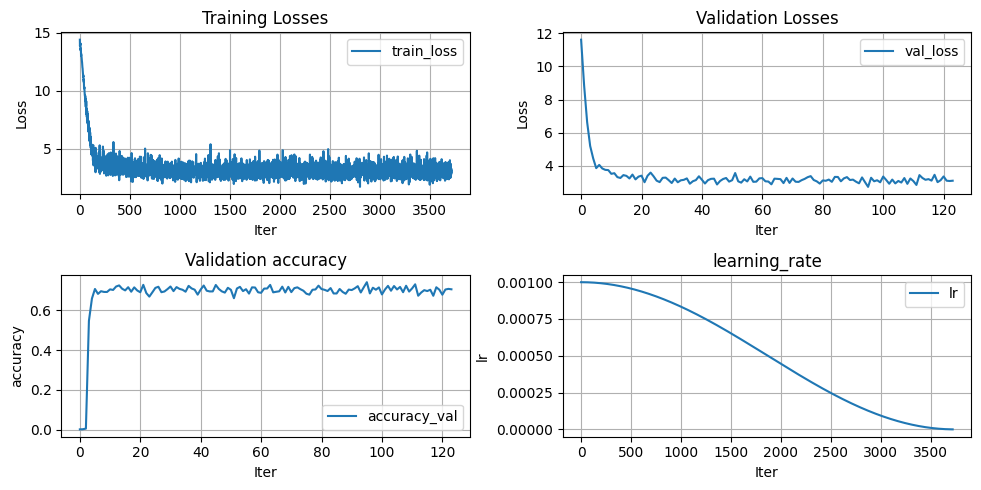

3720
3730


In [18]:
# from torch.optim.lr_scheduler import LinearLR  # Corrected import
import numpy as np

losses = learning_loop(
    p_tuning_model,
    optimizer,
    train_dataloader,
    val_dataloader,
    nn.CrossEntropyLoss(),
    scheduler=scheduler,
    min_lr=None,
    epochs=num_epochs,
    val_every=30,
    draw_every=40,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
)



In [19]:
torch.save(p_tuning_model.prefix_embeddings.data.cpu(), "prefix_embeddings_main.pt")


In [20]:
print(losses['train'])

[14.396316528320312, 13.838592529296875, 13.983942985534668, 13.940935134887695, 14.104302406311035, 13.963412284851074, 14.038800239562988, 13.495820045471191, 13.659285545349121, 13.452438354492188, 13.436389923095703, 13.428642272949219, 12.999899864196777, 13.19182300567627, 13.089838027954102, 13.057882308959961, 13.029821395874023, 12.9087553024292, 12.76318073272705, 12.737180709838867, 12.606586456298828, 12.523420333862305, 12.468278884887695, 12.3295259475708, 12.176712989807129, 11.989818572998047, 11.988716125488281, 11.960774421691895, 11.827317237854004, 11.658605575561523, 11.546850204467773, 11.52776050567627, 11.365023612976074, 11.381396293640137, 11.201202392578125, 11.3117094039917, 10.912470817565918, 10.90445613861084, 10.99311351776123, 10.745573043823242, 10.815763473510742, 10.568669319152832, 10.251837730407715, 10.35405158996582, 10.200429916381836, 10.271739959716797, 10.102685928344727, 9.9197359085083, 9.8756742477417, 9.652840614318848, 9.650501251220703,

In [21]:
print(losses['val'])

[11.61288480758667, 8.847405529022216, 6.637296199798584, 5.2049085140228275, 4.456607055664063, 3.8695716142654417, 4.063614130020142, 3.8506092548370363, 3.766506052017212, 3.750603127479553, 3.5267045736312865, 3.5645750045776365, 3.3287134647369383, 3.2762624979019166, 3.4492701292037964, 3.4034281730651856, 3.2474626779556273, 3.4803598642349245, 3.1911815643310546, 3.3563109159469606, 3.4159519195556642, 3.020280909538269, 3.4101558208465574, 3.6003124713897705, 3.3748518228530884, 3.115027928352356, 3.0270946502685545, 3.2858368158340454, 3.298918294906616, 3.1441038131713865, 2.972430634498596, 3.241941499710083, 3.0168787479400634, 3.1353824138641357, 3.1645365238189695, 3.2504194498062136, 2.929651403427124, 3.0797191619873048, 3.149378514289856, 3.3784363508224486, 3.1675823450088503, 2.9419085502624513, 3.14590437412262, 3.223306727409363, 3.234393048286438, 2.8861886739730833, 3.0927818536758425, 3.21411612033844, 3.275234818458557, 3.0564815521240236, 3.142323040962219, 3

In [22]:
print(losses['accuracy_val'])

[0.002, 0.0026785714285714286, 0.005821428571428571, 0.5464285714285714, 0.6583571428571429, 0.7062142857142857, 0.6816071428571429, 0.6949642857142857, 0.6913928571428571, 0.6912142857142857, 0.7043214285714285, 0.7014285714285714, 0.7185357142857143, 0.7241071428571428, 0.7074642857142858, 0.6991428571428572, 0.7151071428571428, 0.6925714285714286, 0.7143571428571428, 0.6985714285714286, 0.6898214285714286, 0.7269285714285715, 0.6857857142857143, 0.6678928571428572, 0.6894642857142858, 0.7116785714285714, 0.7173928571428572, 0.6900714285714286, 0.6936428571428571, 0.7053571428571429, 0.7186785714285714, 0.6955, 0.7156428571428571, 0.7067142857142857, 0.70225, 0.6925357142857143, 0.7218928571428571, 0.7089285714285715, 0.7026785714285714, 0.6778571428571428, 0.7035714285714286, 0.7235357142857143, 0.6974642857142858, 0.6938928571428571, 0.6940714285714286, 0.7263214285714286, 0.7063571428571429, 0.6941785714285714, 0.6881071428571428, 0.7121785714285714, 0.7019285714285715, 0.65992857

In [23]:
print(losses['lr'])

[0.0009999998236008354, 0.000999999294403466, 0.0009999984124082653, 0.0009999971776158553, 0.0009999955900271077, 0.0009999936496431425, 0.0009999913564653288, 0.0009999887104952846, 0.0009999857117348769, 0.000999982360186222, 0.000999978655851684, 0.0009999745987338774, 0.0009999701888356645, 0.000999965426160157, 0.0009999603107107154, 0.0009999548424909491, 0.0009999490215047166, 0.000999942847756125, 0.0009999363212495308, 0.0009999294419895386, 0.0009999222099810027, 0.000999914625229026, 0.0009999066877389602, 0.000999898397516406, 0.0009998897545672129, 0.0009998807588974792, 0.0009998714105135525, 0.0009998617094220288, 0.0009998516556297533, 0.0009998412491438197, 0.000999830489971571, 0.000999819378120599, 0.0009998079135987434, 0.0009997960964140944, 0.0009997839265749897, 0.0009997714040900164, 0.0009997585289680106, 0.0009997453012180564, 0.0009997317208494878, 0.0009997177878718867, 0.0009997035022950842, 0.0009996888641291603, 0.0009996738733844437, 0.00099965853007151